<a href="https://www.kaggle.com/code/lorresprz/forecasting-sales-with-prophet?scriptVersionId=145318817" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This work is a competition notebook in the Playground series forecasting fictional course sales. Here we used Facebook Prophet - without any customized parameters (such as seasonality mode), additional regressors or exogenous factors - to predict each individual time series in the dataset and combine the results together for submission. Unfortunately, due to the late entry into the submission, there wasn't enough time to explore more sophisticated models or to improve on the existing model. 

In [1]:
from prophet import Prophet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [4]:
import warnings
warnings.filterwarnings("ignore")

## Preliminary data exploration

In [5]:
df = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
df.sample(6)

,id,date,country,store,product,num_sold
110398,110398,2021-01-11,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,443
8556,8556,2017-04-25,Argentina,Kaggle Store,Using LLMs to Train More LLMs,52
50547,50547,2018-11-05,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,74
45156,45156,2018-08-26,Argentina,Kaggle Store,Using LLMs to Train More LLMs,63
40334,40334,2018-06-22,Japan,Kagglazon,Using LLMs to Write Better,502
54509,54509,2018-12-28,Japan,Kagglazon,Using LLMs to Write Better,509


In [6]:
list_store = df['store'].unique()
list_country = df['country'].unique()
list_prod = df['product'].unique()

print(f'Unique country values:', list_country)
print(f'Unique store values: ', list_store)
print(f'Unique products:', list_prod)

Unique country values: ['Argentina' 'Canada' 'Estonia' 'Japan' 'Spain']
Unique store values:  ['Kaggle Learn' 'Kaggle Store' 'Kagglazon']
Unique products: ['Using LLMs to Improve Your Coding' 'Using LLMs to Train More LLMs'
 'Using LLMs to Win Friends and Influence People'
 'Using LLMs to Win More Kaggle Competitions' 'Using LLMs to Write Better']


In what follows, we will extract individual time series in the dataset (there are 74 of them), and call each time series  $Y[i,j,k]$ where 

 - $i = 0, \ldots, 4$ labels  *country* 
 - $j = 0, \ldots, 2$ labels *store*
 - $k = 0, \ldots, 4$ labels *product* 

In [7]:
#Extract the time series Y_ijk corresponding to country i, store j, product k
Y = {}
for i in range(len(list_country)):
    for j in range(len(list_store)):
        for k in range(len(list_prod)):
            Y[i,j,k] = df[(df['country']==list_country[i])& (df['store']==list_store[j]) & (df['product']==list_prod[k])]
            Y[i,j,k] = Y[i,j,k].drop(['country','store','product'], axis = 1)
            Y[i,j,k]['date'] = pd.to_datetime(Y[i,j,k]['date'])

In [8]:
#Display an example: (i,j,k)= (0,0,2)
Y[0,0,2]

,id,date,num_sold
2,2,2017-01-01,9
77,77,2017-01-02,7
152,152,2017-01-03,7
227,227,2017-01-04,7
302,302,2017-01-05,6
...,...,...,...
136577,136577,2021-12-27,5
136652,136652,2021-12-28,6
136727,136727,2021-12-29,7
136802,136802,2021-12-30,7


In [9]:
#write a function to plot the time series of 'num_sold' vs 'date' for any chosen values of the tuple (i,j,k)
def plot_time_series(i,j,k):
    fig, ax = plt.subplots(figsize = (36,12))
    #ax.plot(x, y, linewidth=2.0)
    ax.plot( Y[i,j,k]['date'], Y[i,j,k]['num_sold'], color = 'C2')
    #sns.lineplot(x='date', y='num_sold', data=Y0)
    ax.set_xlabel('date', fontsize = 24)
    ax.set_ylabel('num_sold', fontsize = 24)
    ax.set_title(list_prod[k]+ '---'+ list_country[i] +'---'+ list_store[j] ,
                 fontsize=36)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.show()

Plot a few time series Y[i,j,k] to visualize

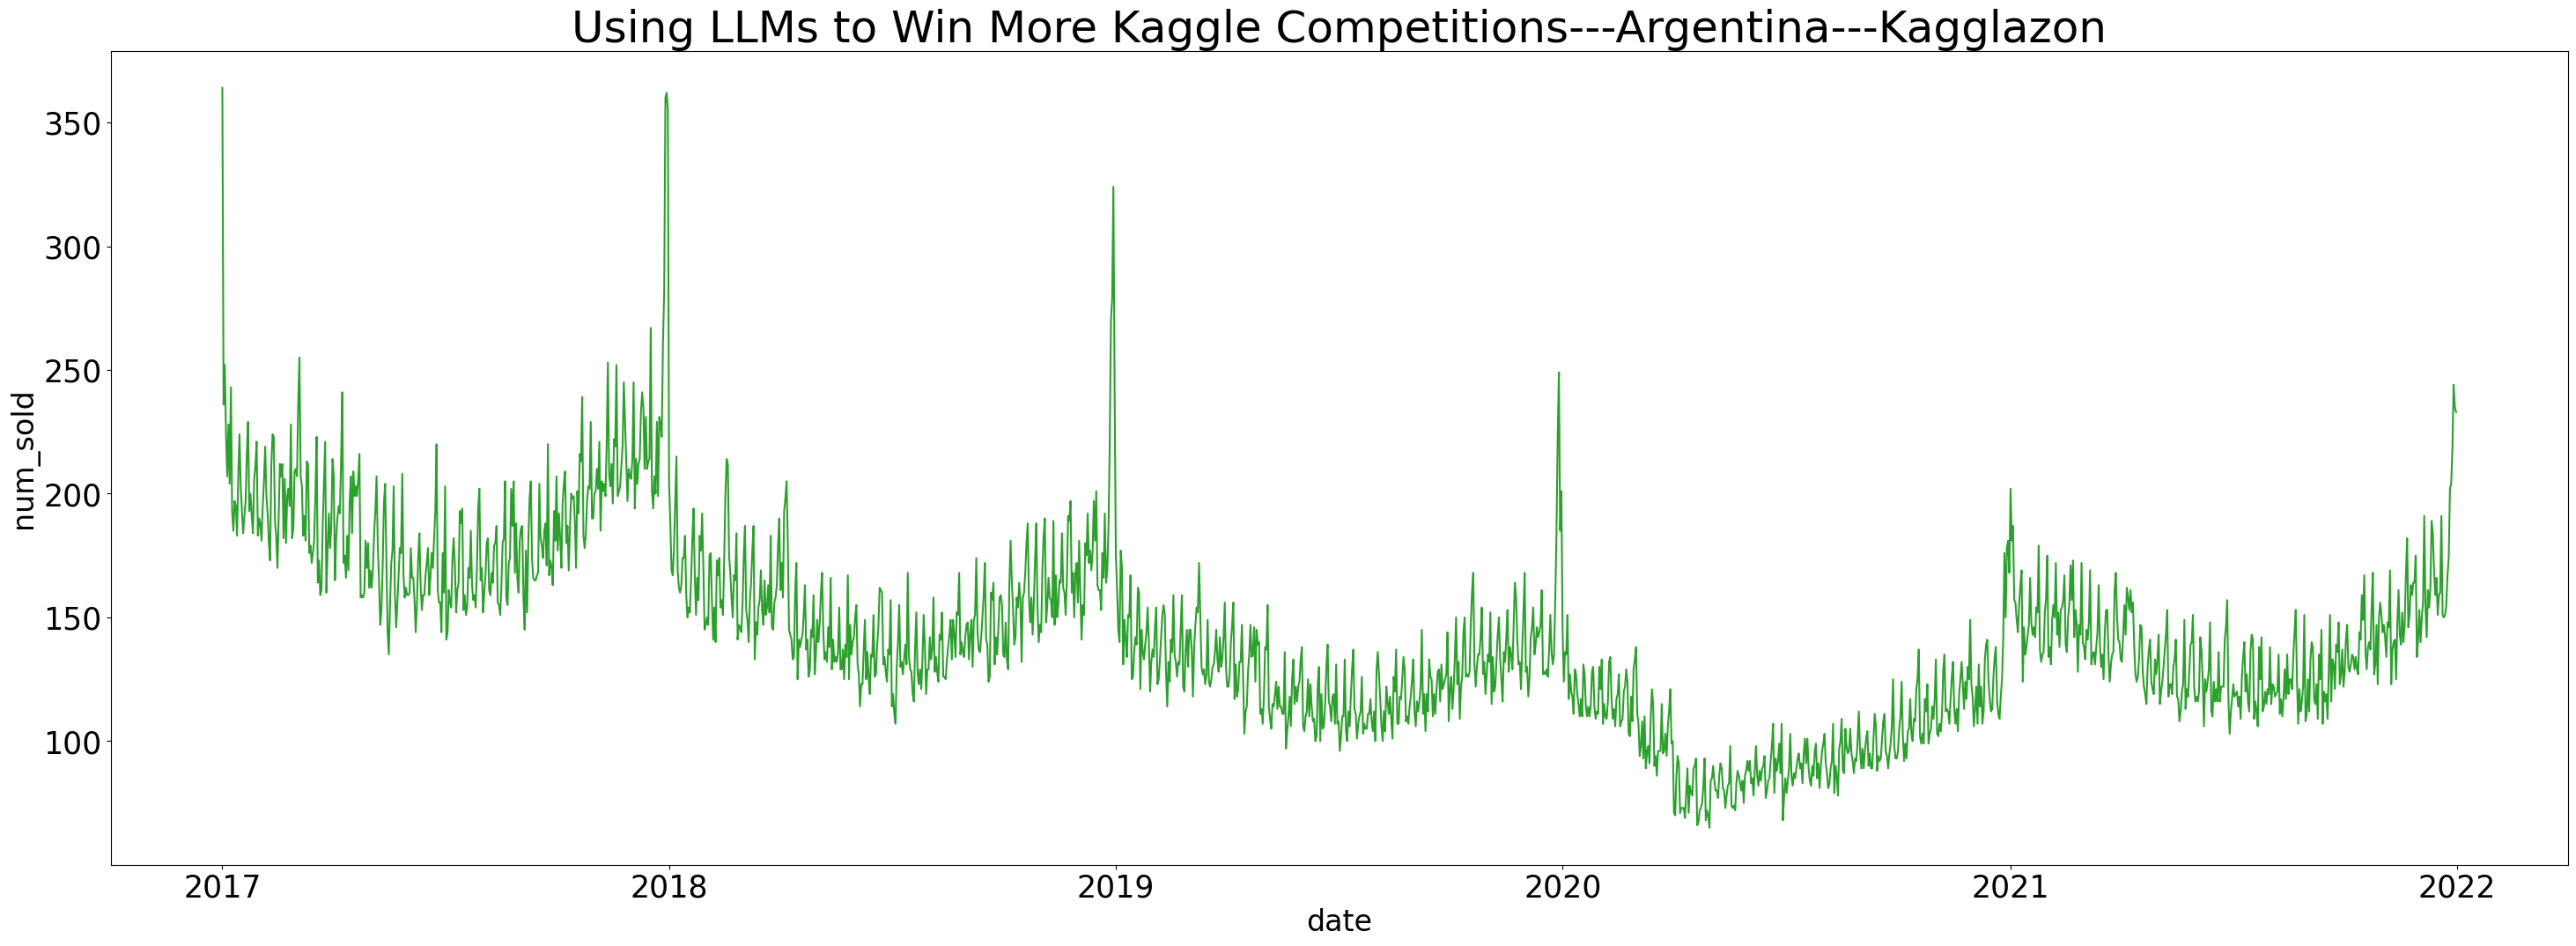

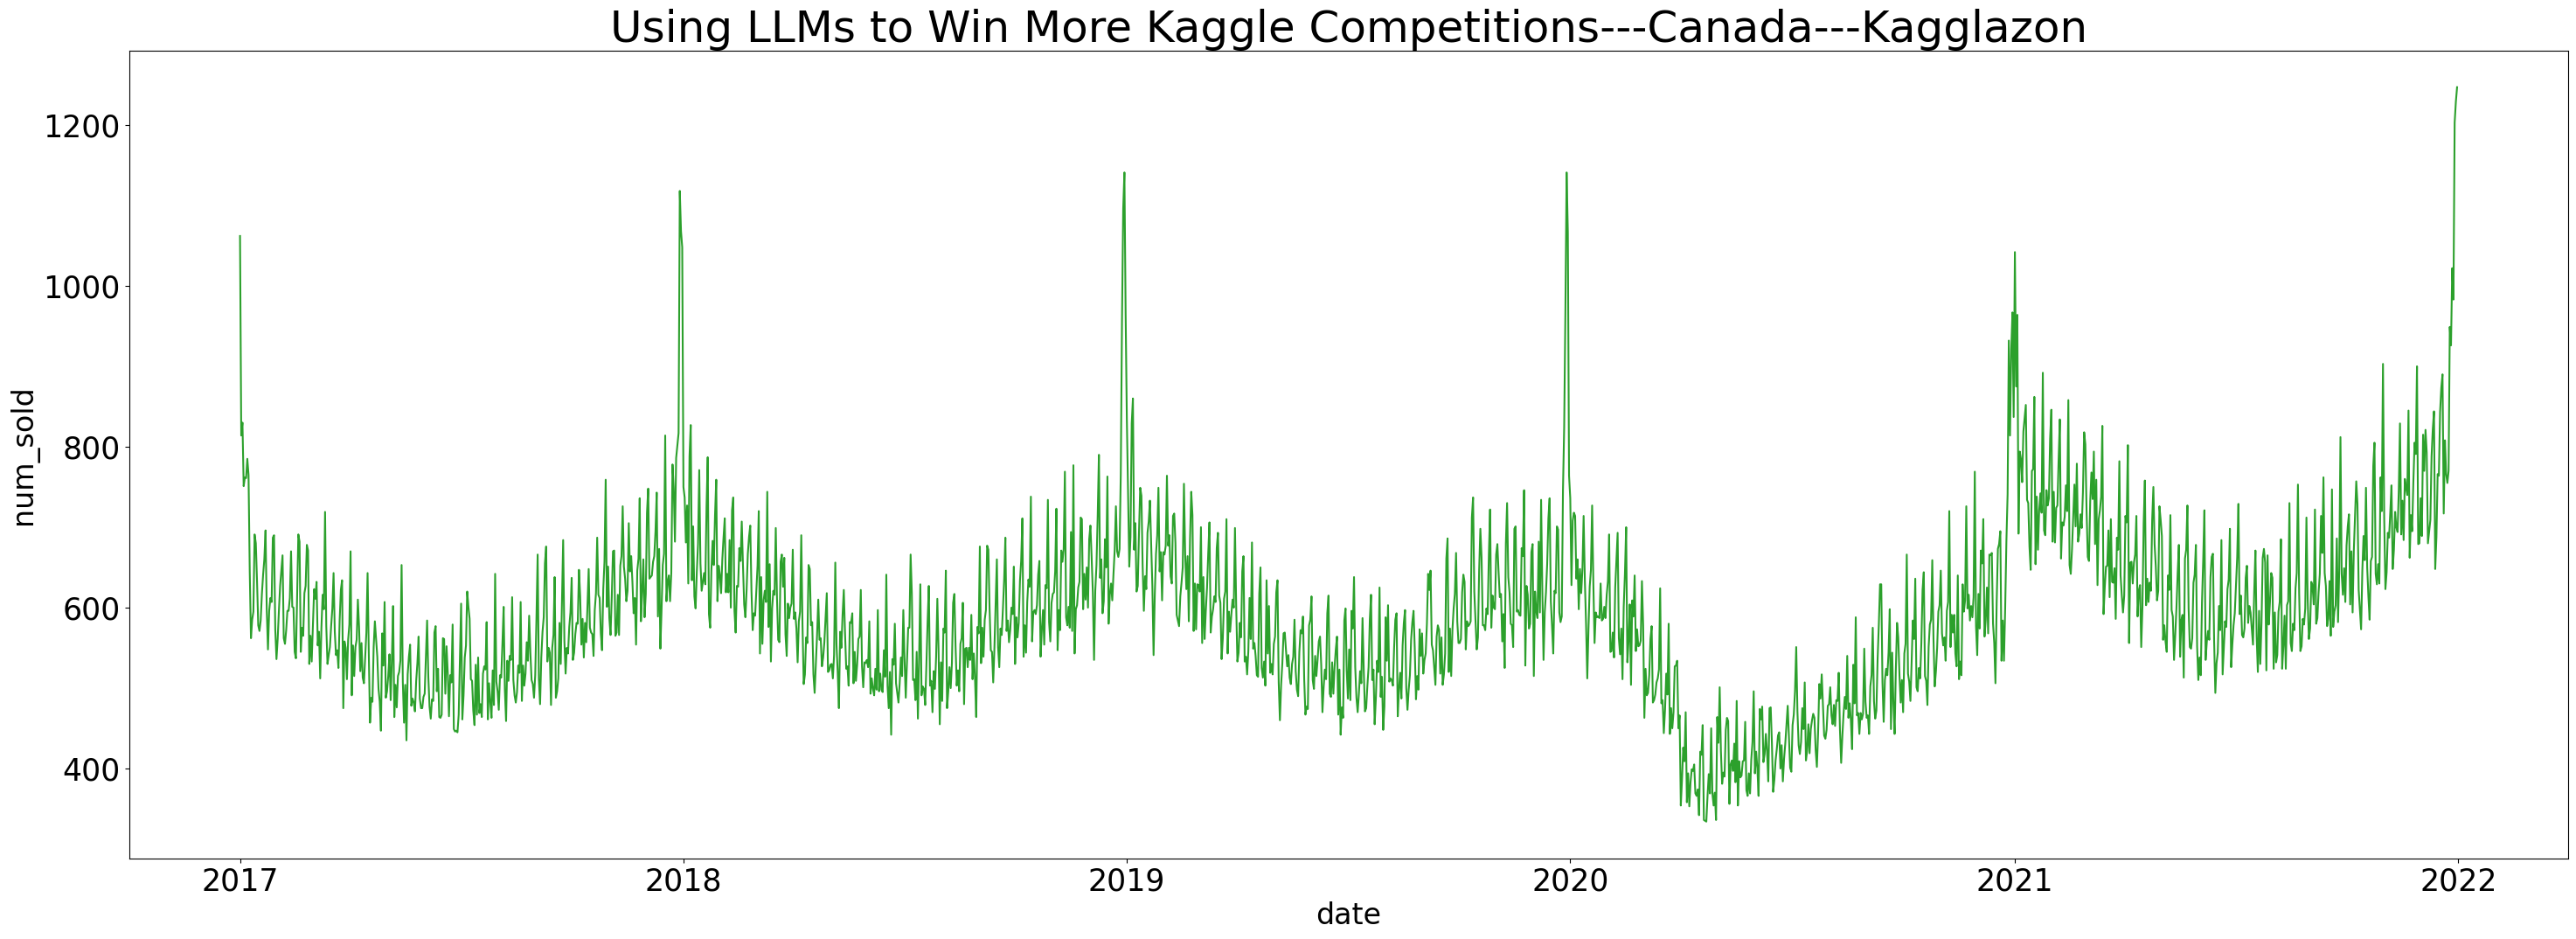

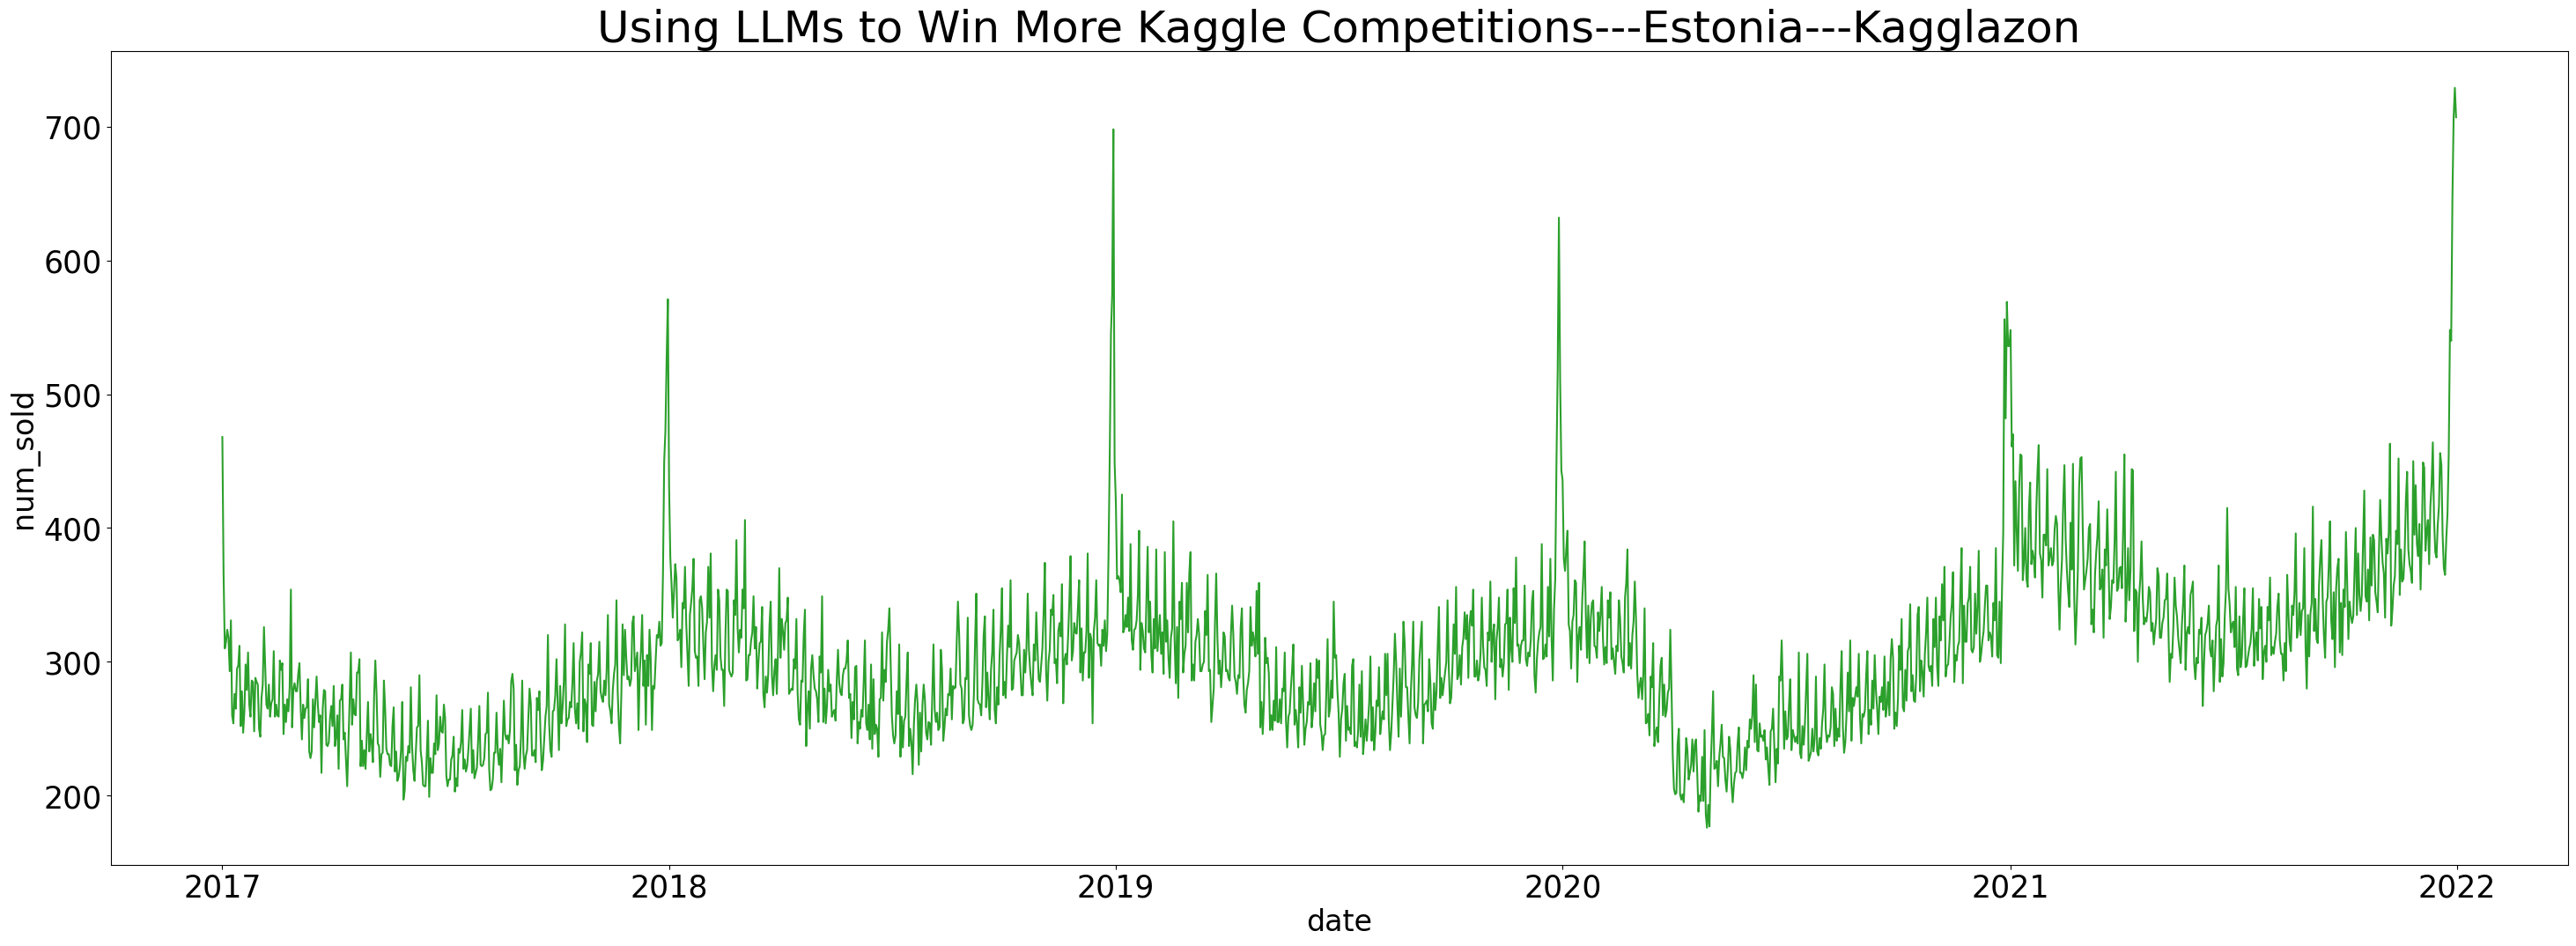

In [10]:
for i in range(3):
    for j in range(2,3):
        for k in range(3,4):
            plot_time_series(i,j,k)

## Using Prophet to predict

In [11]:
#Test dataset 
df_test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')
df_test.sample(6)

,id,date,country,store,product
4344,141294,2022-02-27,Spain,Kaggle Store,Using LLMs to Write Better
24097,161047,2022-11-18,Canada,Kaggle Store,Using LLMs to Win Friends and Influence People
26753,163703,2022-12-23,Japan,Kaggle Store,Using LLMs to Win More Kaggle Competitions
2219,139169,2022-01-30,Estonia,Kagglazon,Using LLMs to Write Better
17529,154479,2022-08-22,Japan,Kaggle Store,Using LLMs to Write Better
25638,162588,2022-12-08,Spain,Kaggle Learn,Using LLMs to Win More Kaggle Competitions


In [12]:
#Extract the time series Y_ijk for df_test 
#Yt only contains the date data for 2022 and the 'id' column,but no value for 'num_sold'
Yt = {}
for i in range(len(list_country)):
    for j in range(len(list_store)):
        for k in range(len(list_prod)):
            Yt[i,j,k] = df_test[(df_test['country']==list_country[i])& (df_test['store']==list_store[j]) & (df_test['product']==list_prod[k])]
            Yt[i,j,k] = Yt[i,j,k].drop(['country','store','product'], axis = 1)
            Yt[i,j,k]['date'] = pd.to_datetime(Yt[i,j,k]['date'])
            Yt[i,j,k] = Yt[i,j,k].set_index('id')

In [13]:
#check the format for a Yt[i = 0, j = 1, k = 2]:
Yt[0,1,2]

,date
id,
136957,2022-01-01
137032,2022-01-02
137107,2022-01-03
137182,2022-01-04
137257,2022-01-05
...,...
163957,2022-12-27
164032,2022-12-28
164107,2022-12-29


In [14]:
#Create an empty list to store 365 predictions (2022 values) for all Y[i,j,k] series
pred_list = np.empty((len(list_country), len(list_store), len(list_prod), 365))
pred_list.shape

(5, 3, 5, 365)

In [15]:
#Create an empty list to store 2191 predictions (2017-2022 values) for all Y[i,j,k] series
pred_list_full = np.empty((len(list_country), len(list_store), len(list_prod), 2191))
pred_list_full.shape

(5, 3, 5, 2191)

Next, we create a loop to loop through all $(i,j,k)$ values in which Prophet is used to predict the next 365 days worth of sales for each $Y[i,j,k]$ series. To achieve this goal, the block of code below does the following: 

- For each tuple $(i,j,k)$ representing a single time series, $Y[i,j,k]$ is the dataframe holding values for 'id', 'date', 'num_sold' from 01-01-2017 to 31-12-2021. $\texttt{Prophet()}$ is used to generate the next 365 values from 01-01-2022 to 31-12-2022.

- The output of $\texttt{Prophet()}$ for each $(i,j,k)$ is stored in a dataframe called '$\texttt{forecast'}$. This is a dataframe holding generated values (stored in the column called 'yhat' of $\texttt{forecast'}$) for all time, ranging from 01-01-2017 to 31-12-2022. 
    - The values of 'yhat' corresponding to the period of 01-01-2022 to 31-12-2022 (index 1826 onwards) are extracted  and then stored in $\texttt{pred_list}[i,j,k]$. 
    - The values of 'yhat' corresponding to the FULL period of 01-01-2027 to 31-12-2022  are extracted  and then stored in $\texttt{pred_list_full}[i,j,k]$. These are useful for generating plots comparing real and forecast values for all time. 

- For better clarity, the results for each $(i,j,k)$ tuple are assigned to a series called $Yt[i,j,k]$ that contains 'id', 'date', 'num_sold' for the period of 01-01-2022 to 31-12-2022.

In [16]:
#These are used to silent some of the warnings and verbose outputs
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

for i in range(len(list_country)):
    for j in range(len(list_store)):
        for k in range(len(list_prod)):                      
            #input dataframe
            dfi = Y[i,j,k][['date', 'num_sold']].copy()
            #renaming the columns of the input dataframe to Prophet's format
            dfi.columns = ['ds', 'y']
            m = Prophet()
            m.fit(dfi)
            #Create another dataframe holding future date values
            ft = m.make_future_dataframe(periods = 365)
            #Calling m.predict returns another dataframe
            forecast = m.predict(ft)
            
            #Extract the forecast values for 2022 stored in 'yhat' 
            pred_list[i,j,k] = forecast['yhat'][1826:]
            #Extract the forecast values for all time (2017-2022) stored in 'yhat' 
            pred_list_full[i,j,k] = forecast['yhat']
            
            #Store the 365 predictions for 2022 in Yt[i,j,k]
            y_test_idx = Yt[i,j,k][Yt[i,j,k]['date']>='2022-01-01'].index
            Yt[i,j,k].loc[y_test_idx, 'num_sold'] = pred_list[i,j,k]

09:02:55 - cmdstanpy - INFO - Chain [1] start processing
09:02:55 - cmdstanpy - INFO - Chain [1] done processing
09:02:56 - cmdstanpy - INFO - Chain [1] start processing
09:02:56 - cmdstanpy - INFO - Chain [1] done processing
09:02:57 - cmdstanpy - INFO - Chain [1] start processing
09:02:57 - cmdstanpy - INFO - Chain [1] done processing
09:02:58 - cmdstanpy - INFO - Chain [1] start processing
09:02:58 - cmdstanpy - INFO - Chain [1] done processing
09:02:59 - cmdstanpy - INFO - Chain [1] start processing
09:02:59 - cmdstanpy - INFO - Chain [1] done processing
09:03:00 - cmdstanpy - INFO - Chain [1] start processing
09:03:00 - cmdstanpy - INFO - Chain [1] done processing
09:03:00 - cmdstanpy - INFO - Chain [1] start processing
09:03:01 - cmdstanpy - INFO - Chain [1] done processing
09:03:02 - cmdstanpy - INFO - Chain [1] start processing
09:03:02 - cmdstanpy - INFO - Chain [1] done processing
09:03:03 - cmdstanpy - INFO - Chain [1] start processing
09:03:03 - cmdstanpy - INFO - Chain [1]

# Visualize a few generated time series 

We want to visualize a few time series showing the generated part for the period of 01/01/2017 to 31/12/2022, alongside with the real values for the period of 01/01/2017 to 31/12/2021. To do this, we need to construct a dataframe holding these values for each $(i,j,k)$ tuple. 

In [17]:
Yb = {}
for i in range(len(list_country)):
    for j in range(len(list_store)):
        for k in range(len(list_prod)):
            #use only the column 'ds' of the last generated 'forecast' dataframe
            #these are just the date values ranging from 01012017 to 31122022
            Yb[i,j,k] = forecast[['ds']]
            #create a column called 'predicted' holding 2191 values for all time
            Yb[i,j,k]['predicted'] = pred_list_full[i,j,k]
            #create a column called 'real' holding value only for 2017-2021
            train_idx = Yb[i,j,k].index <= 1825
            test_idx = Yb[i,j,k].index>1825
            Yb[i,j,k].loc[train_idx,'real'] = Y[i,j,k]['num_sold'].to_numpy()
            #set index to date
            Yb[i,j,k] =  Yb[i,j,k].set_index('ds')
            

In [18]:
#check the final format for a single series, e.g.(i,j,k) = (0,0,0)
Yb[0,0,0]

,predicted,real
ds,,
2017-01-01,47.369124,63.0
2017-01-02,41.268022,51.0
2017-01-03,40.739140,44.0
2017-01-04,40.514692,44.0
2017-01-05,40.250970,40.0
...,...,...
2022-12-27,38.451490,NaN
2022-12-28,38.621479,NaN
2022-12-29,38.737375,NaN


In [19]:
def plot_both_time_series(i,j,k):
    fig, ax = plt.subplots(figsize = (36,12))
    Yb[i,j,k][['real', 'predicted']].plot(ax = ax)
    ax.set_xlabel('date', fontsize = 32)
    ax.set_ylabel('num_sold', fontsize = 32)
    ax.set_title(list_prod[k]+ '---'+ list_country[i] +'---'+ list_store[j] ,
                 fontsize=36)
    plt.legend(["real", "predicted"], fontsize="30", loc ="upper right")
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.show()

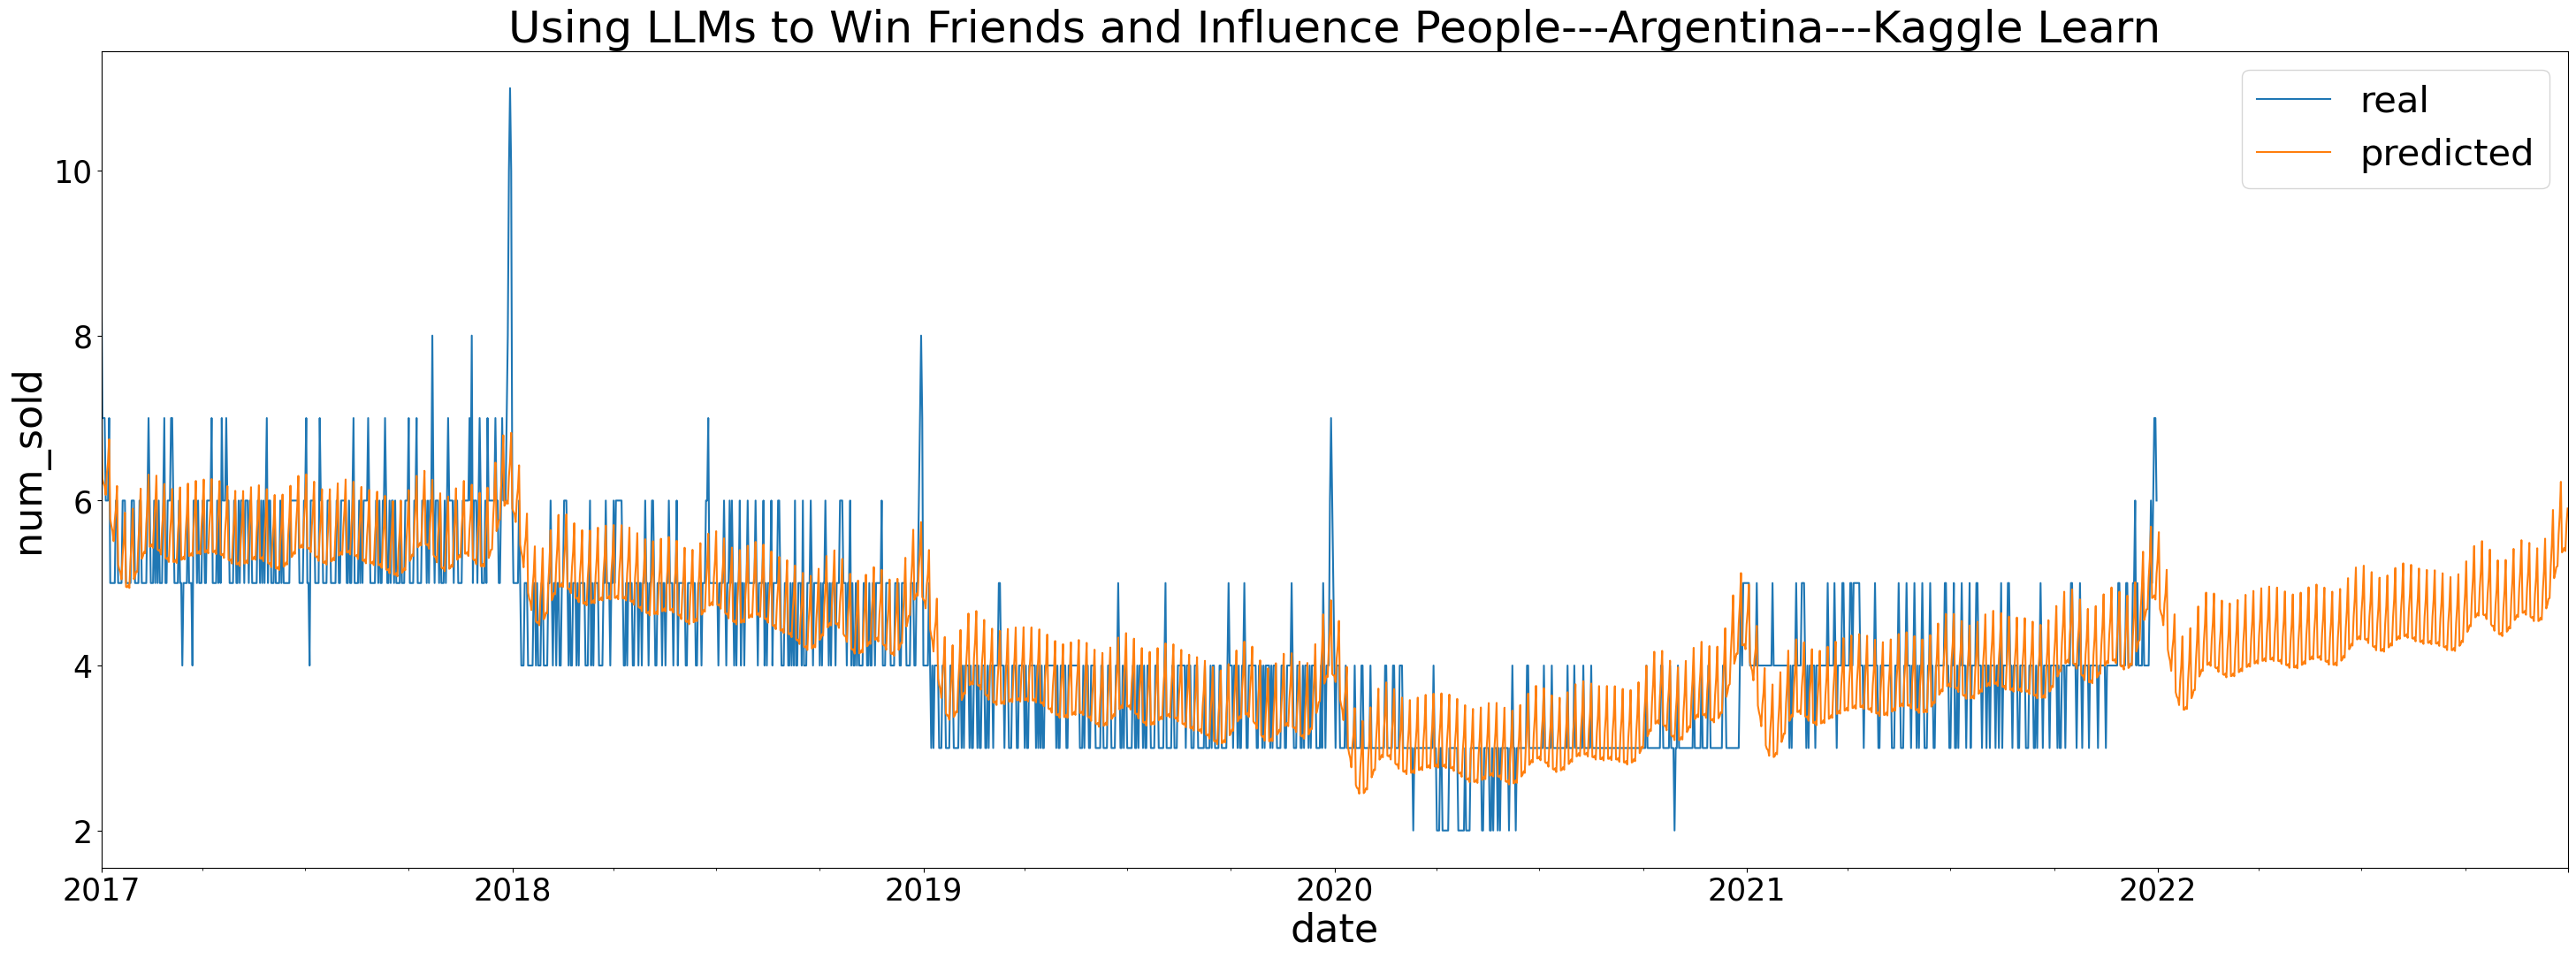

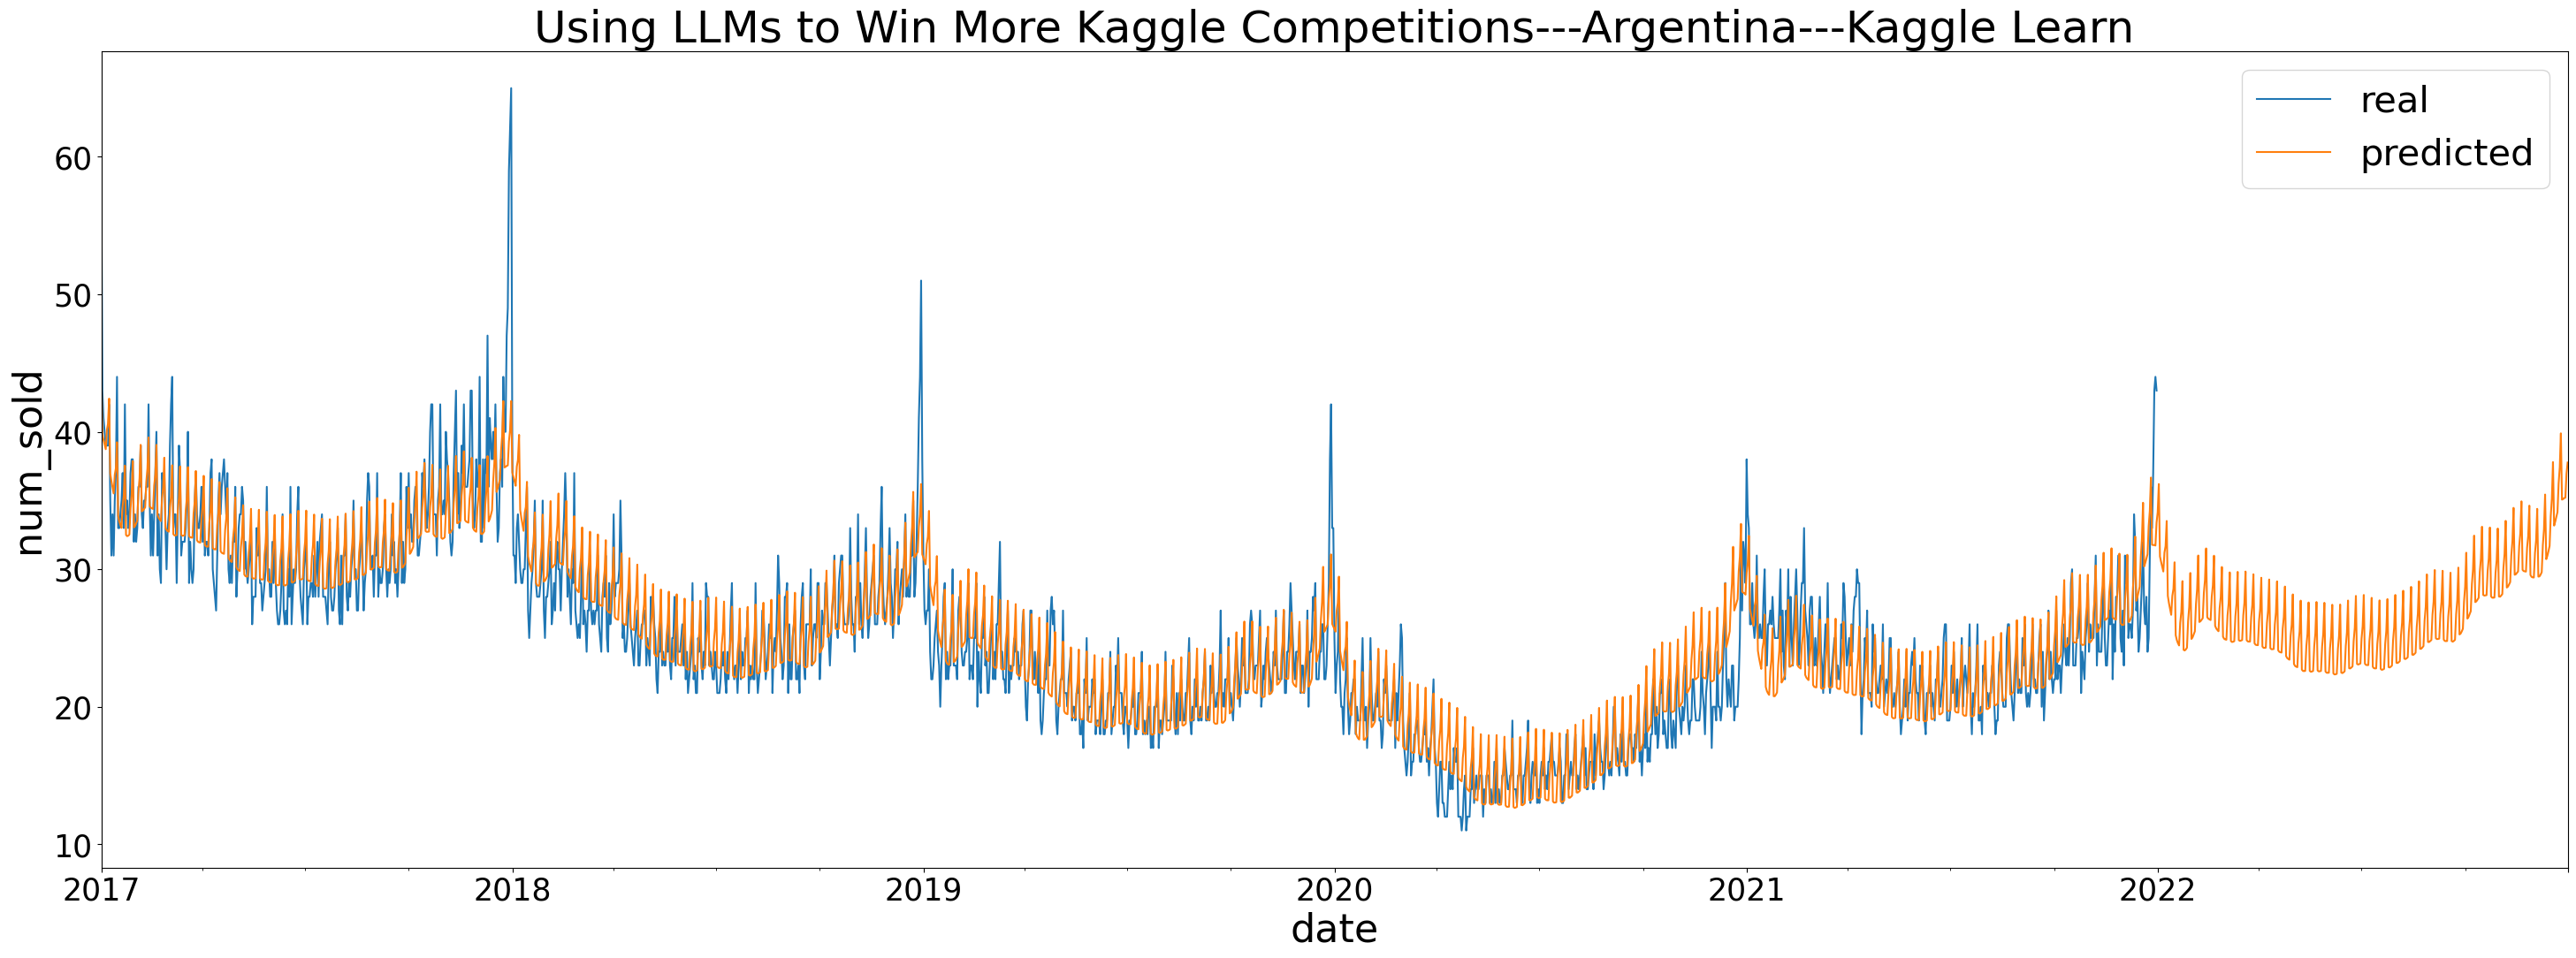

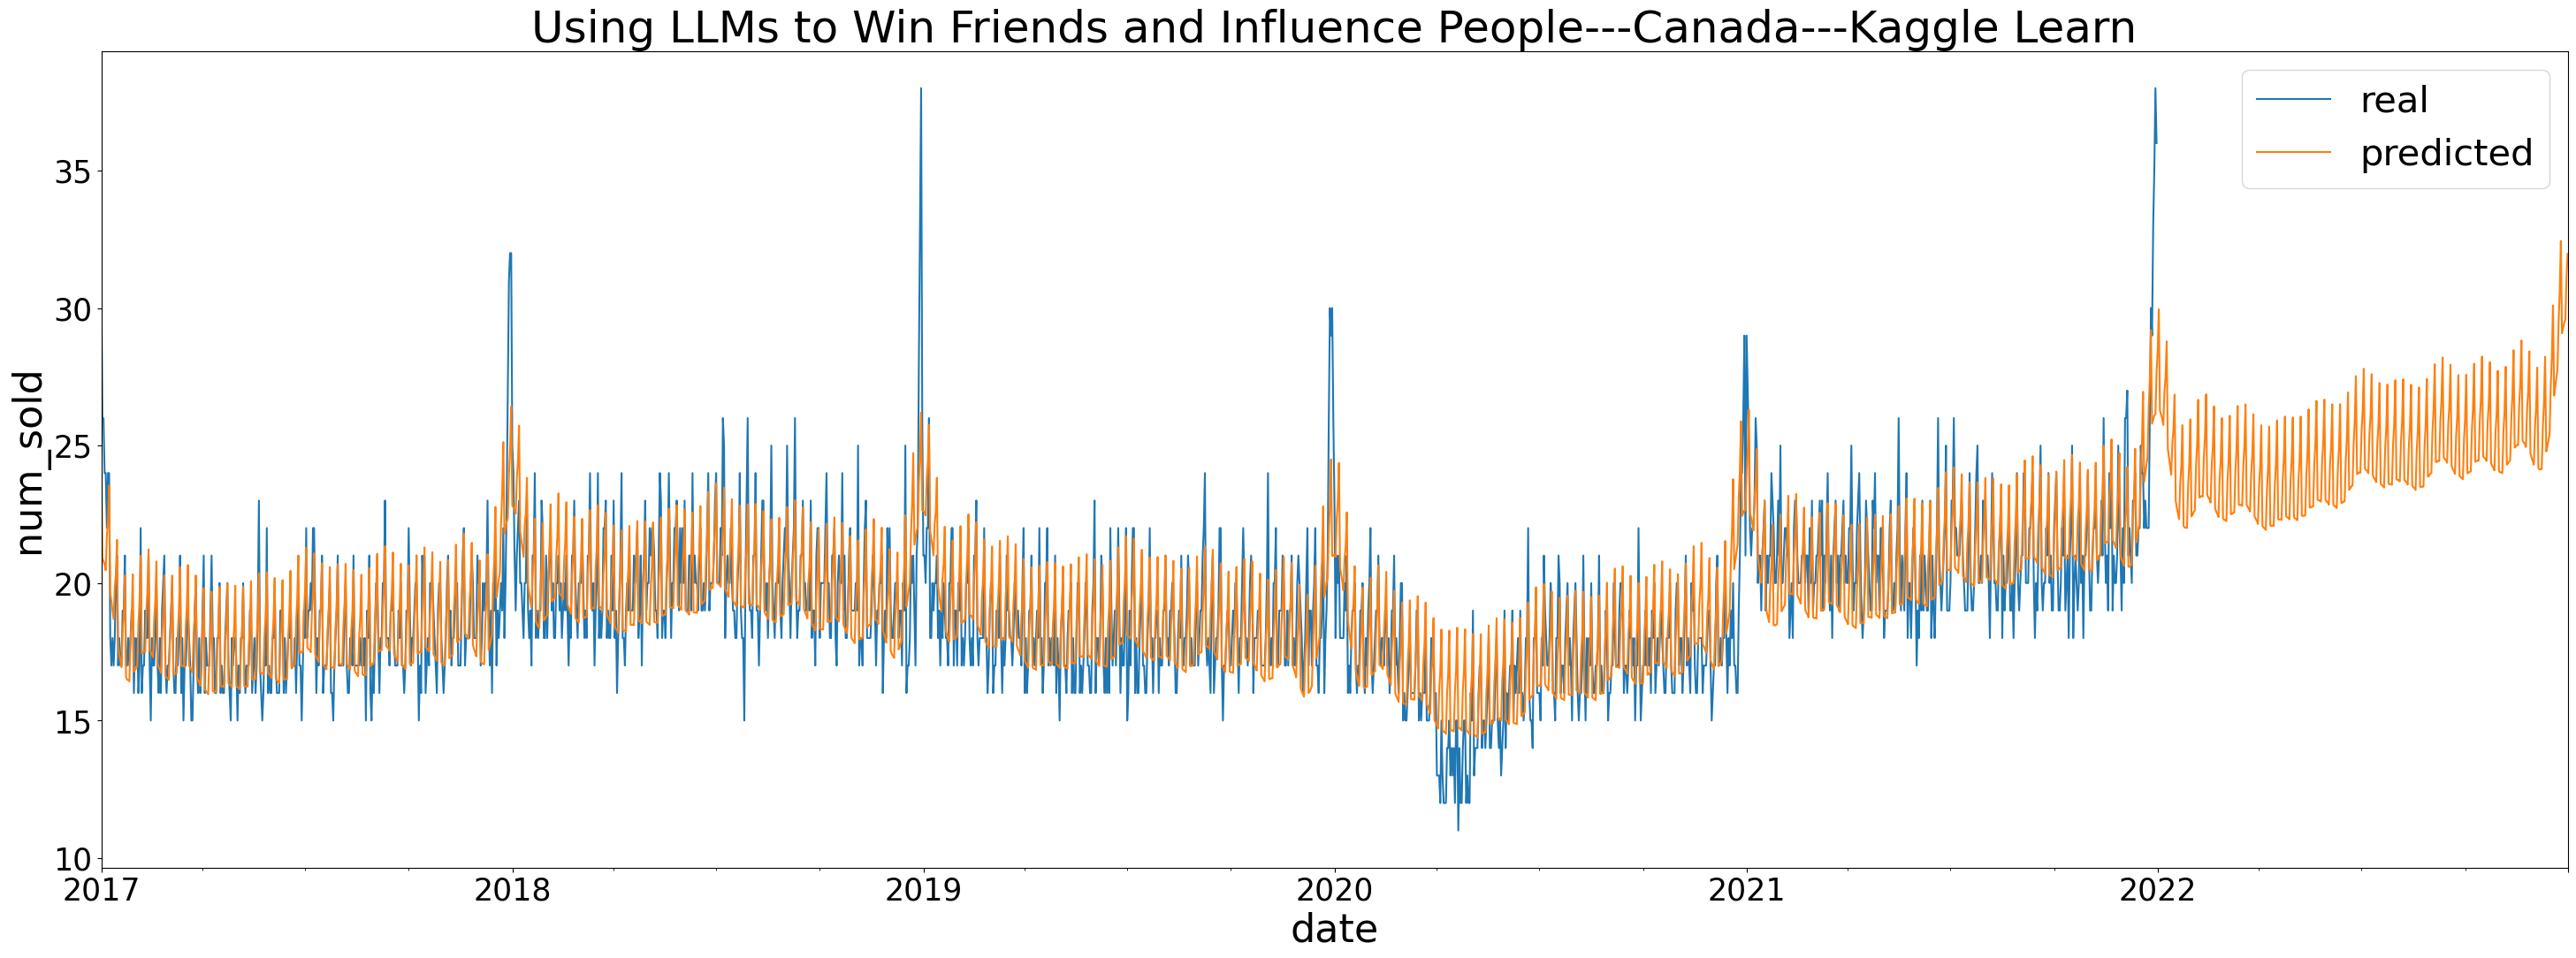

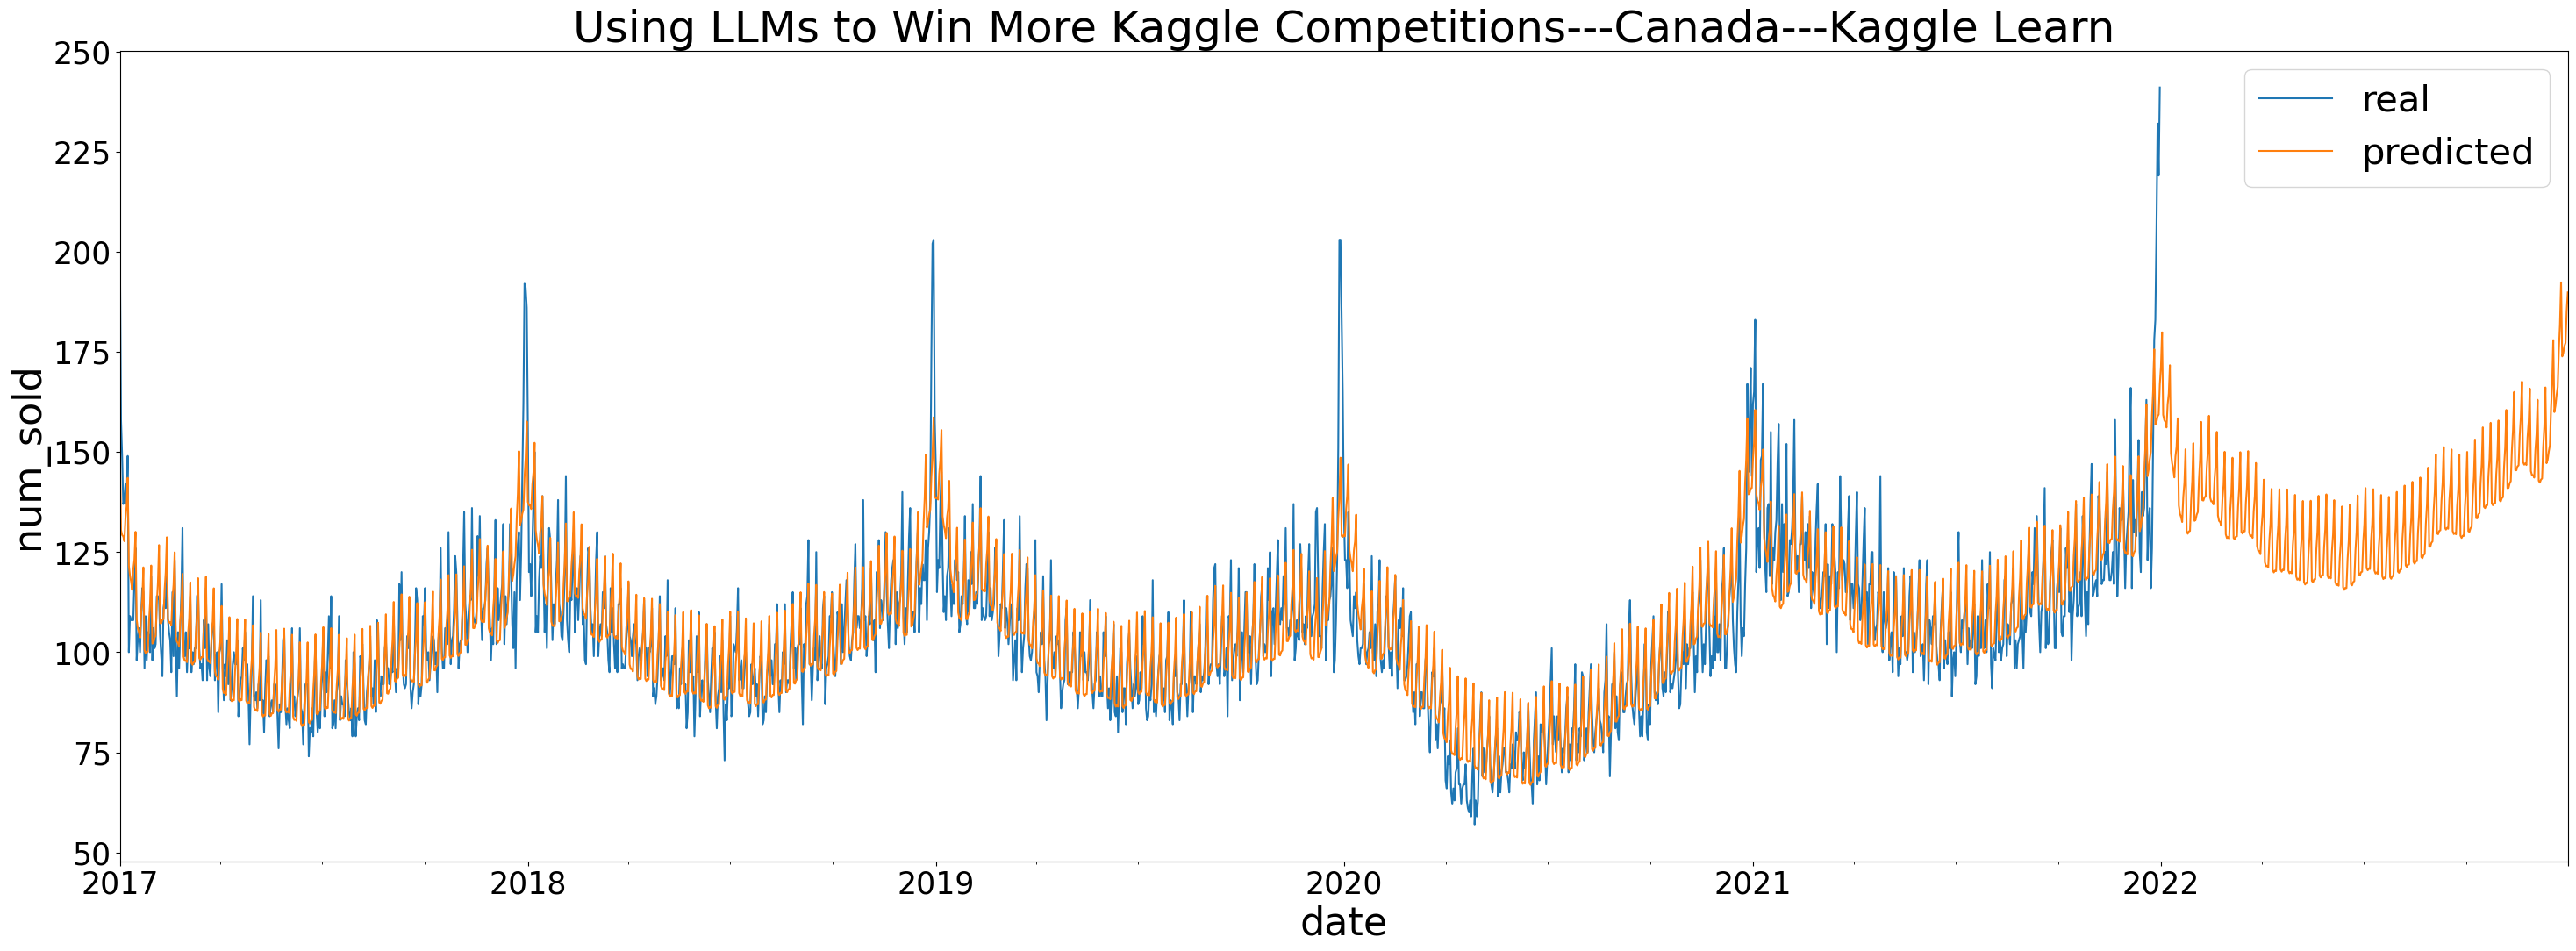

In [20]:
for i in range(2):
    for j in range(1):
        for k in range(2,4):
            plot_both_time_series(i,j,k)

## Preparing submission file

In [21]:
#Concatenate all Y series together to form a single dataframe
df_p = Yt[0,0,0]
for i in range(len(list_country)):
    for j in range(len(list_store)):
        for k in range(len(list_prod)):
            #This will add (0,0,0) again so need to get rid of (0,0,0) afterwards
            df_p = pd.concat([df_p, Yt[i,j,k]])

In [22]:
#Get rid of the first 365 values corresponding to the extra (0,0,0)
df_putback = df_p[365:]

In [23]:
df_putback = df_putback.sort_values(by ='id')

In [24]:
df_putback.sample(6)

,date,num_sold
id,,
156020,2022-09-12,280.769376
151845,2022-07-18,112.062149
137993,2022-01-14,134.158664
148068,2022-05-29,139.412186
140306,2022-02-14,576.207155
150373,2022-06-28,360.927350


In [25]:
df_sub = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')


In [26]:
df_sub['num_sold'] = np.round(df_putback['num_sold'].to_numpy())

In [27]:
df_sub.to_csv('submission.csv', index = False)